# Customer Churn Forecasting

### Objective: To analyze customer churn and come up with customer retention strategy 

The goals for this study:
 - predict the probability of churn (for the upcoming month) for each customer
 -draw up typical user portraits: select the most outstanding groups and describe their main features
 - analyze the factors that impact churn most
 - draw basic conclusions and develop recommendations on how to improve customer service
        

### Data Description

`Churn` — the fact of churn for the month in question

Current dataset fields:
- User data for the preceding month
 - `gender`
 - `Near_Location` — whether the user lives or works in the neighborhood where the gym is located
 - `Partner` — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
 - `Promo_friends` — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
 -`Phone` — whether the user provided their phone number
 - `Age`
 - `Lifetime` — the time (in months) since the customer first came to the gym
 
Data from the log of visits and purchases and data on current membership status
 - `Contract_period` — 1 month, 3 months, 6 months, or 1 year
 - `Month_to_end_contract` — the months remaining until the contract expires
 - `Group_visits` — whether the user takes part in group sessions
 - `Avg_class_frequency_total` — average frequency of visits per week over the customer's lifetime
 - `Avg_class_frequency_current_month` — average frequency of visits per week over the preceding month
 - `Avg_additional_charges_total` — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

## Step1. Import Data

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


In [223]:
from io import BytesIO
import requests
spreadsheet_id = '1cDhrmYjw1KVQFKZ7z9VRMEFV-TDaqdyimFf8or2bjQc'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
gym = pd.read_csv(BytesIO(r.content))
display(gym.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int64  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

First look, the dataset contains 4000 customer entries and as we can see there are no null values. We do need to change the column to lower string for uniformity.

In [224]:
# Changing column to lower case
gym.columns = [x.lower() for x in gym.columns]

## Step 2. Carry out exploratory data analysis (EDA)

In [225]:
display(gym.sample())
display(gym.head())

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
1858,1,1,1,1,1,12,1,32,234.740234,12,8,2.124864,2.069892,0


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


###  Does it contain any missing features? Study the mean values and standard deviation

In [226]:
display(gym.describe())


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


As we said above, no missing values present. It also shows most customers lived near a gym location and most of the customers are not recommended or used a promotion code from a friend. The average contract period is about 5 months

Average customer's age is 29. Client spend about $150 on other gym services such as cafe, massages,etc. The average  amount of time that a customer has on their contract is 4 months and about half only have a month left. Gym clients go about twice a week on average. Customer churn rate is 26%

In [227]:
#Check for duplicates
gym.duplicated().sum()

0

No duplicate data found so we can proceed

In [228]:
gym['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

### Look at the mean feature values in two groups: for those who left (churn) and for those who stayed

In [229]:
gym.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Now we look at the mean feature values between two groups: those who left and those that stayed. There are an even distribution of both genders among the gym customers. Those that stayed with their contract lives close to the gym and about half are affiliated with the company.It shows that most people that did not renew their contract also lives near the gym location and not affiliated with the company. 

Most of the users that did not renew,about 18% was not brought by a friend while the ones that stayed averaged about 35% of the users. The share of customers who take part in group sessions are 46% of users who stayed and 26% of users that left. Age averaged about 26 and 29 for those that did not renew and renewed.

There are about 5 months in average left in the contract for those users that did renew and about 2 months for those that did not renew their contract. The lifetime of loyal customers are about 4 months while the ones that left worked out for a month or less.

Customers that stayed visited about twice a week while the ones that left visited once a week in average

### Plot bar histograms and feature distributions for those who left (churn) and those who stayed

In [230]:
# Separate columns
feature_cols = ['gender', 'near_location', 'partner',
                 'promo_friends', 'phone', 'group_visits', 
                 'contract_period','age',
                 'month_to_end_contract','lifetime' ]
numeric_cols = ['avg_additional_charges_total', 
                'avg_class_frequency_total',
                'avg_class_frequency_current_month']

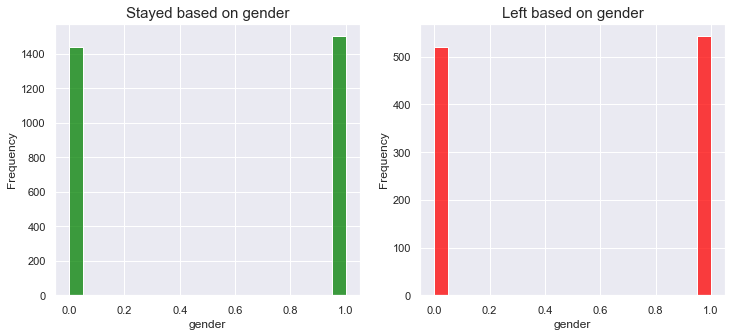

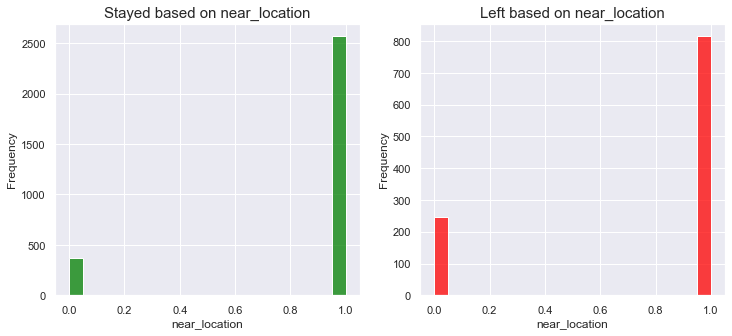

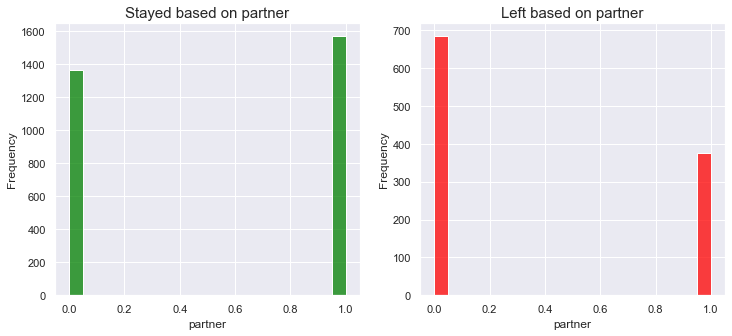

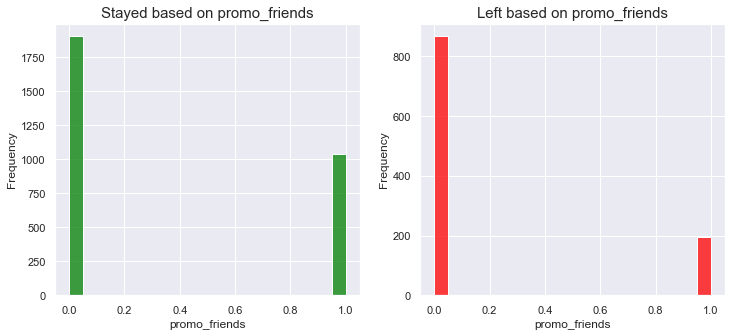

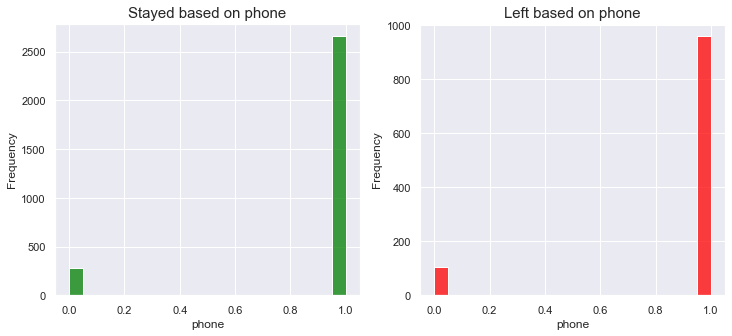

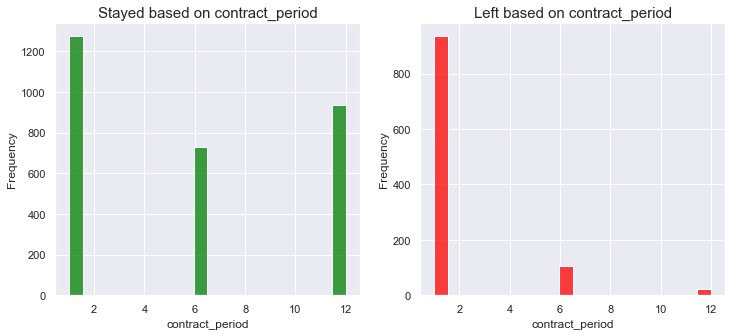

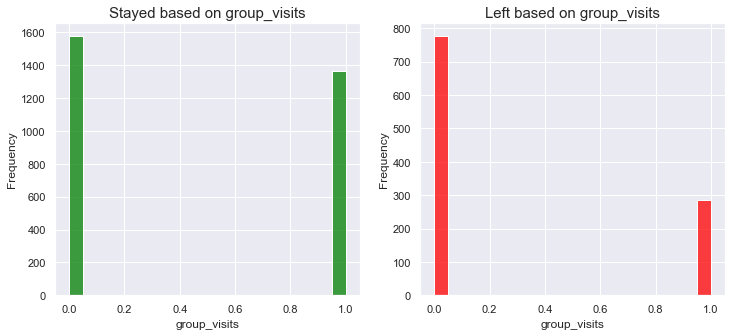

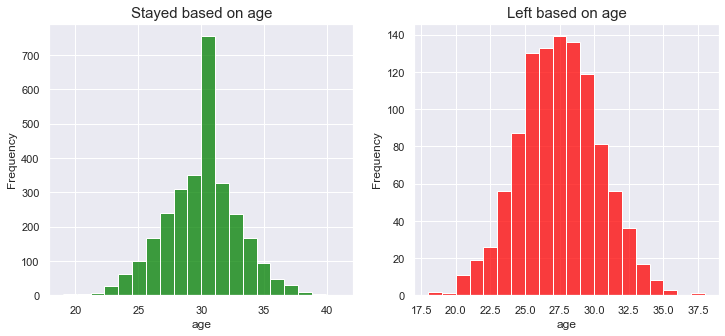

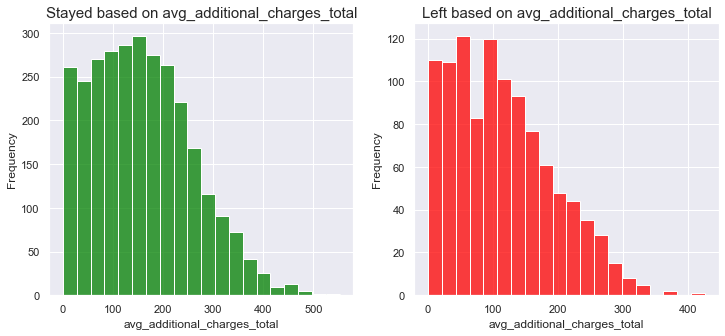

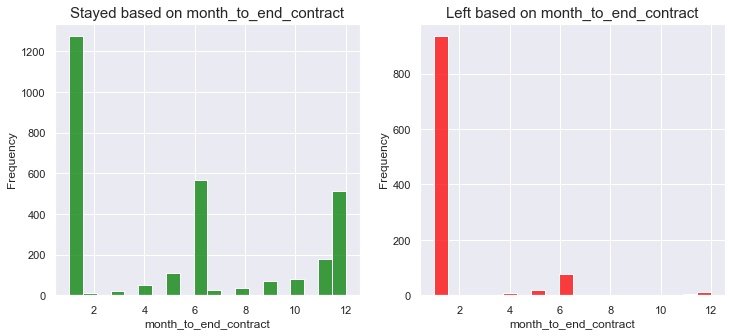

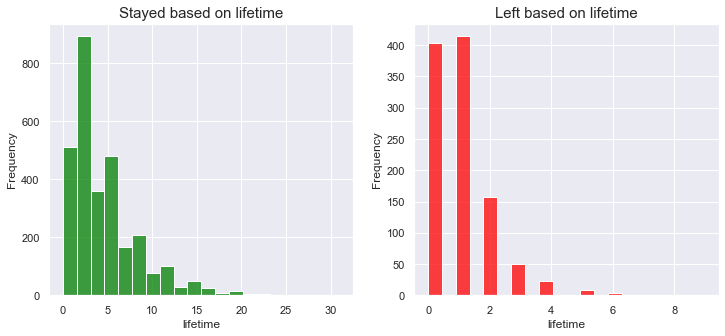

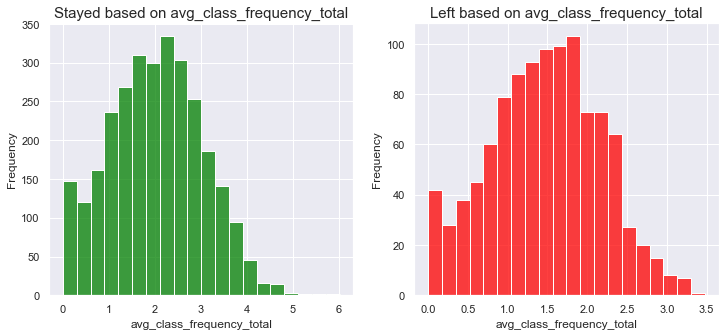

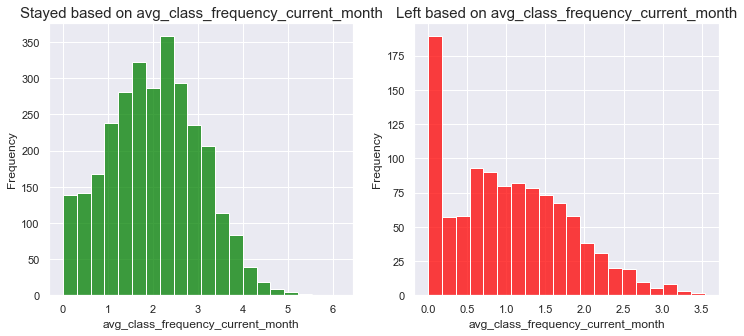

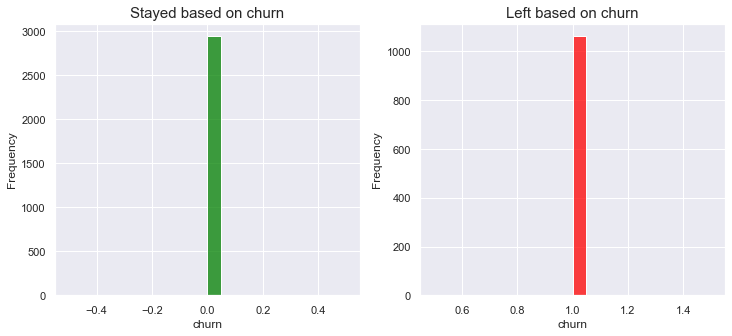

In [231]:
#plot histogram
for col in gym.columns:
    fig,axes = plt.subplots(1,2,figsize=(12,5))
    sns.set(style='darkgrid')
    sns.histplot(gym.query('churn==0')[col], ax=axes[0], color='green', bins=20)
    axes[0].set_title('Stayed based on ' + col, fontsize=15)
    axes[0].set_ylabel('Frequency')
    sns.histplot(gym.query('churn==1')[col], ax=axes[1], color='red', bins=20)
    axes[1].set_title('Left based on ' + col, fontsize=15)
    axes[1].set_ylabel('Frequency')
    plt.show()
    

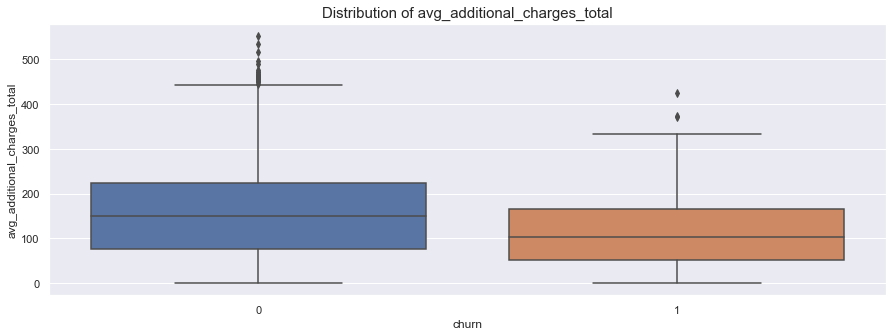

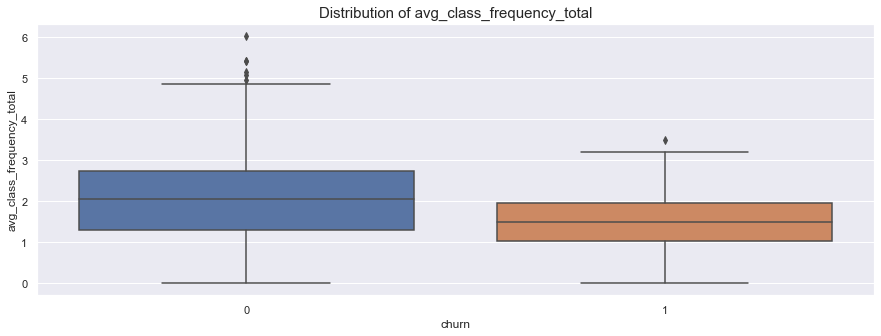

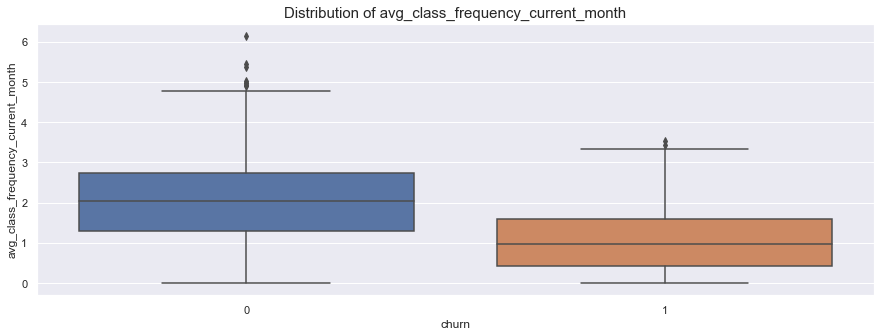

In [243]:
#Plot boxplot for numerical features
for col in numeric_cols:
    plt.figure(figsize=(15,5))
    sns.boxplot(x='churn', y=gym[col], data=gym).set_title('Distribution of ' + col, fontsize=15)
    plt.show()


Based on the graph above, there is about the same share of women and men that left and stayed based on `gender`.
For `near_location`, more clients that live near the gym stayed than those that left, which makes sense.

For `partner`(whether or not the client is an employee of a partner company) there is a large share of clients who did not churn; whether they are affiliated to company or not. This feature might not be a good indicator of whether clients churn or not but it's good to point out for those that left: clients not affiliated with the company are twice as likely to leave than those that are affiliated.

For `promo_friends`, there is a large share of clients that stayed and did not get a promo from a friend. This indicates that the promo might not be that good because it did not really impact whether clients stay or not.

For `phone`(whether or not the user provided their phone number), more than twice of the clients who provided their phone number stayed with the gym company. This is more than likely because the gym contacted them to remind them about their contracts expiration and persuade them to renew it.

For `contract_period`, clients with a 1 month contract are most likely to stay, although a lot of the them left as well. The first month are most likely a trial period.

There is about the same share of clients that participated and did not participate in group sessions(`group_visits`) that stayed and renewed their contracts.

Clients that are younger than 27 have a higher churn rate in comparison to those that are older. Clients that stayed with the gym spent a substantial amount of money on other gym services while the ones that left did not spend a lot on extra services provided by the gym.

For `month_to_end_contract`, clients are likely to decide whether to renew or not with 1 month remaining on their contracts.

Based on `lifetime`,  most clients that did not renew their contracts are members for about 2 months. However, clients that stayed are members for more than 2 months.

Clients that did not churn visited the gym more frequently than the ones that churned. A large share of clients that did not visit the gym last month churned in comparison to the ones that visited and stayed.



### Build a correlation matrix and display it

In [233]:
cg = gym.corr()

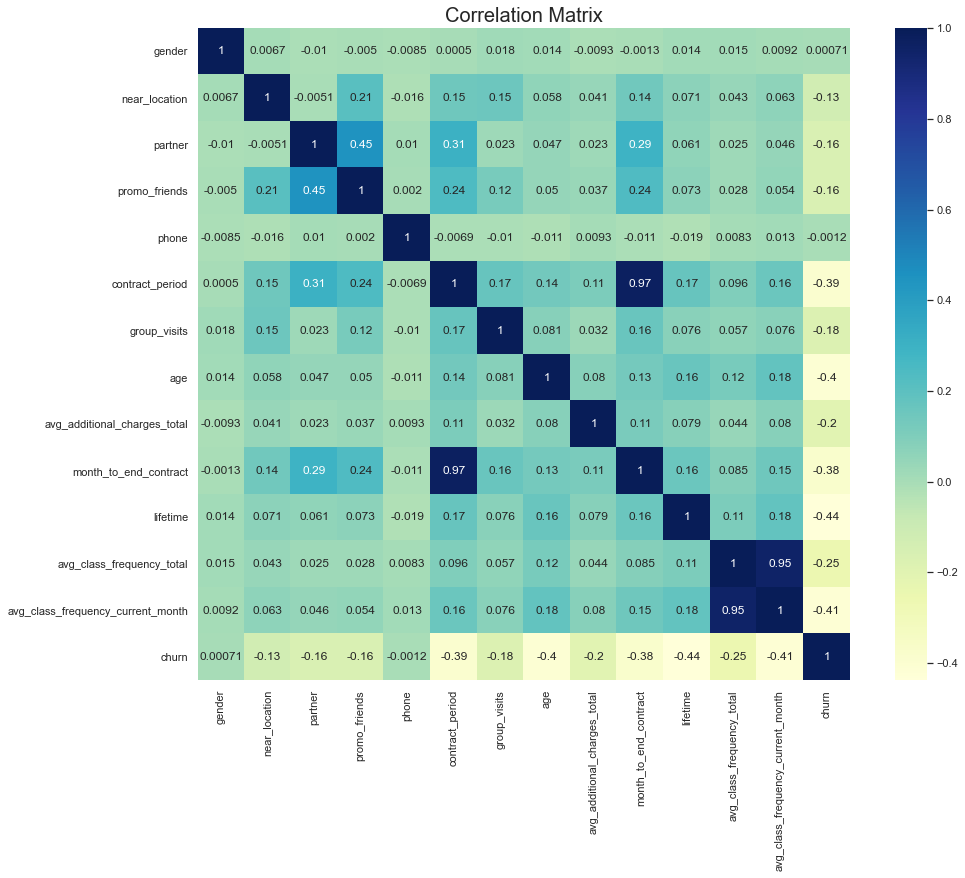

In [234]:
#plot correlation matrix
plt.figure(figsize=(16,12))
sns.heatmap(cg, annot=True,cmap='YlGnBu', square=True)
plt.title('Correlation Matrix',fontsize=20)
plt.show()

Features `month_to_end_contract` and `contract_period` have a strong correlation which is .97. `avg_class_frequency_total` and `avg_class_frequency_current_month` also have a strong correlation although these two features are closely related. The monthly calculation is a proportion of the total.

Features `gender` and `phone` correlation with the target variable `churn` is close to  zero. The remaining features have weak correlation.

## Step 3. Build a model to predict user churn

In [235]:
#Divide the data into target variable and features
X= gym.drop('churn', axis=1)
y= gym['churn']

# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# create a StandardScaler object and apply it to the train set
scaler = StandardScaler()

# train the scaler and transform the matrix for the train set
X_train_st = scaler.fit_transform(X_train)

# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)


# declare models
models = [LogisticRegression(random_state=0),RandomForestClassifier(random_state=0)]

# the function that takes the model and data as input and outputs metrics
def make_prediction(model, X_train, y_train, X_test, y_test):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    #print('Model: ',model)
    print('Accuracy:{:.2f}'.format(accuracy_score(y_test, y_pred))),
    print('Precision:{:.2f}'.format(precision_score(y_test, y_pred))),
    print('Recall:{:.2f} '.format(recall_score(y_test, y_pred)))

for model in models:
    print('\033[1m',model,'\033[0m')
    make_prediction(model,X_train_st, y_train, X_test_st,y_test)


 LogisticRegression(random_state=0) 
Accuracy:0.92
Precision:0.85
Recall:0.83 
 RandomForestClassifier(random_state=0) 
Accuracy:0.92
Precision:0.84
Recall:0.81 


- Accuracy tells us how often we can expect our model will correctly predict an outcome out of the total number of times it made predictions. The two models gave the same result
- Precision score represents the model’s ability to correctly predict the positives out of all the positive predictions it made. Logistic Regression gave a higher score than RandomForest.
- Recall score represents the model’s ability to correctly predict the positives out of actual positives. LogisticRegression gave a higher score than randommforest model
- Logistic regression model gave a slightly better result than the random forest model 

## Step 4. Create user clusters

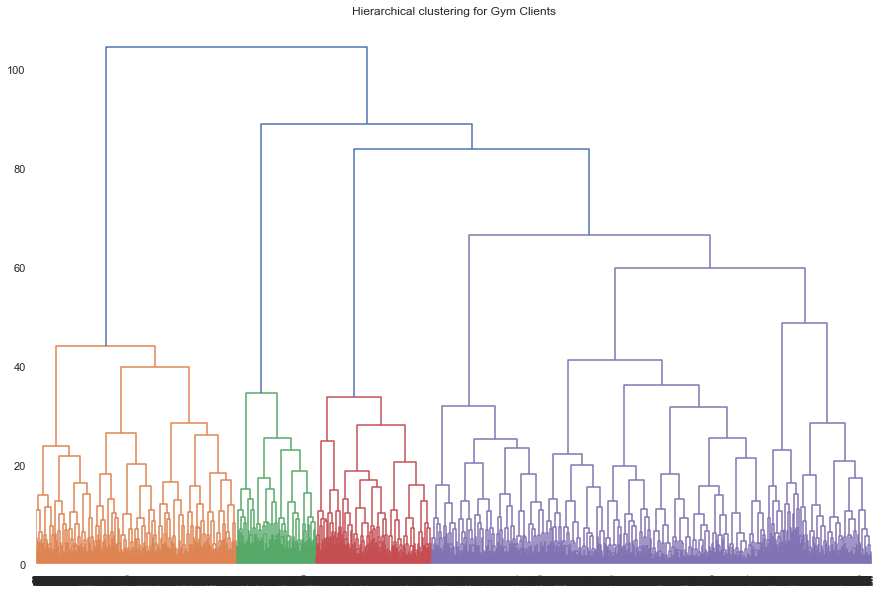

In [236]:
#Standardize data
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Build a maxtrix of distances based on standardize feature matrix
linked = linkage(X_sc, method = 'ward') 

#Plot a dendogram
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for Gym Clients')
plt.show() 

### Train model with K-means algorithm 

In [237]:
#setting the number of clusters as 5
km = KMeans(n_clusters = 5, random_state=0) 

#applying the algorithm to the data and forming a cluster vector 
labels = km.fit_predict(X_sc) 

#get the cluster labels
gym['cluster'] = labels


### Look at the mean feature values for the clusters and plot distribution  of features

In [238]:
cluster_df = gym.groupby('cluster').mean().round(4)
display(cluster_df.T)

cluster,0,1,2,3,4
gender,0.5221,0.4808,0.5596,0.5096,0.4957
near_location,0.8623,0.8126,0.8580,0.7503,0.9434
partner,0.4701,0.0000,0.3381,1.0000,0.7521
promo_friends,0.3065,0.0862,0.1974,0.4520,0.5417
phone,0.0000,1.0000,0.9988,1.0000,1.0000
contract_period,4.7870,1.8669,2.7304,2.5544,11.3526
group_visits,0.4260,0.3252,0.4489,0.3035,0.5641
age,29.3013,28.1453,30.1961,28.4994,29.9936
avg_additional_charges_total,143.9577,131.3690,164.5790,129.8125,164.5638
month_to_end_contract,4.4753,1.7910,2.5199,2.3700,10.3761


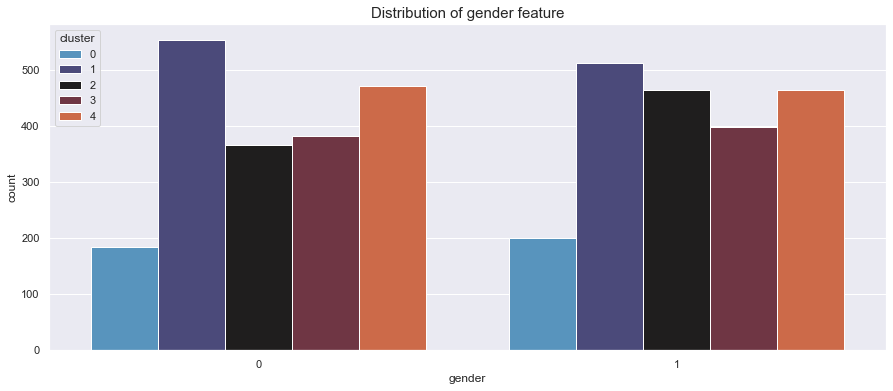

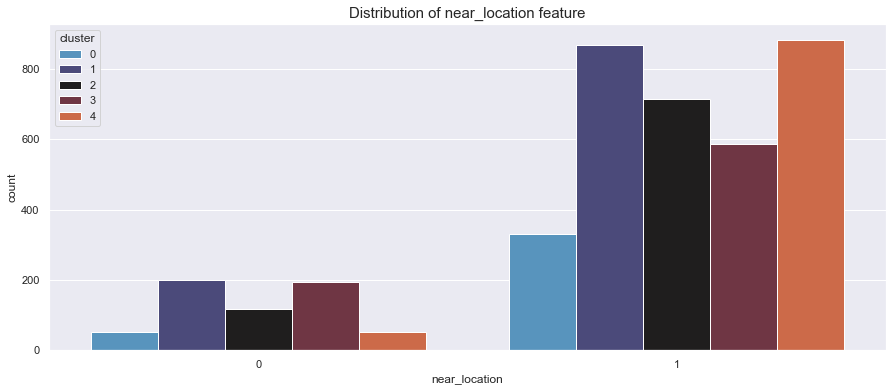

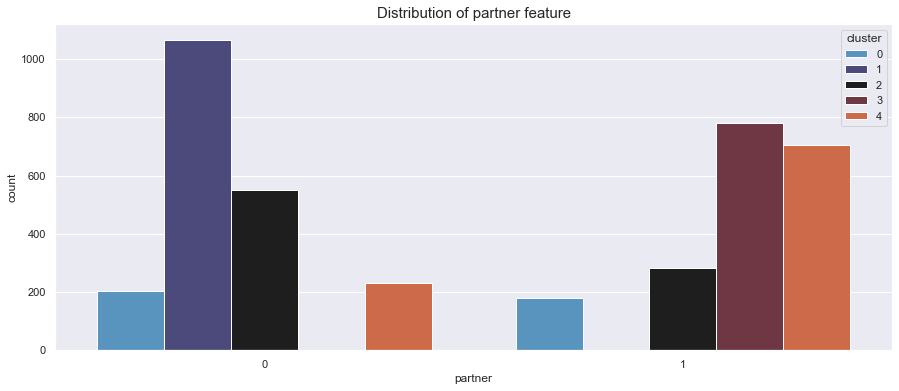

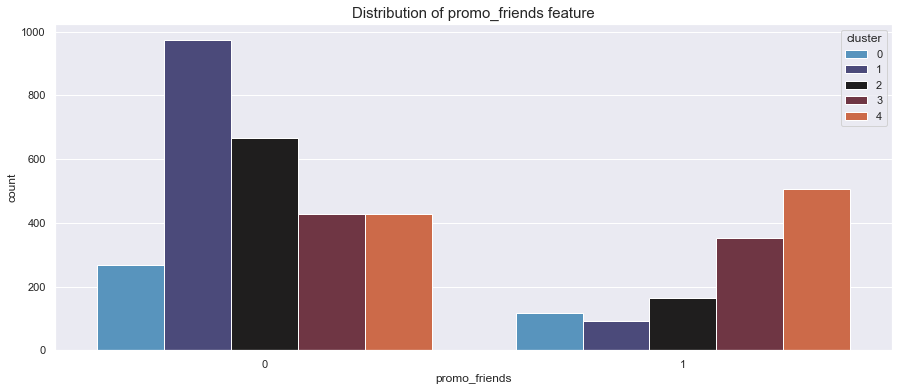

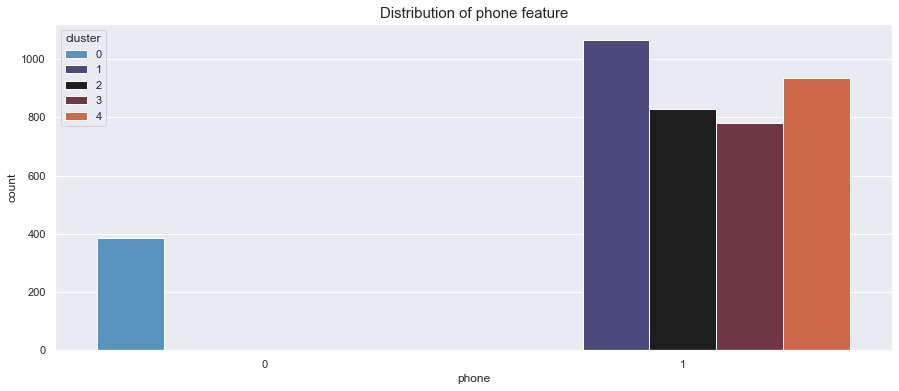

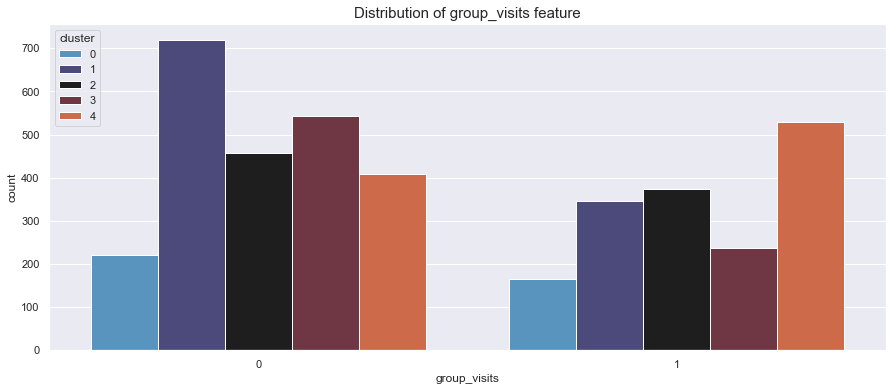

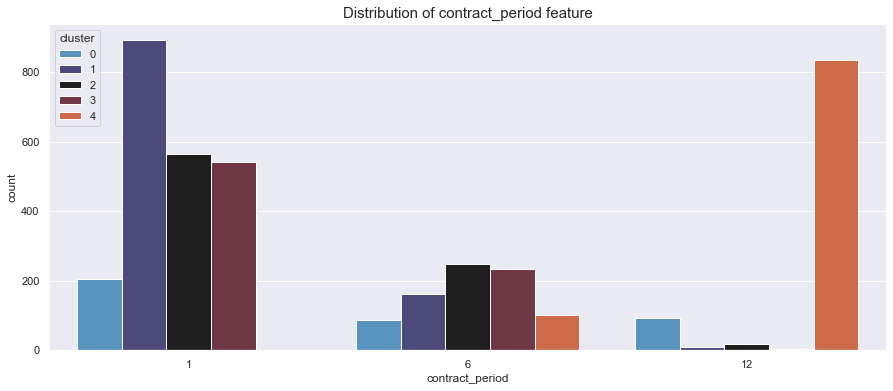

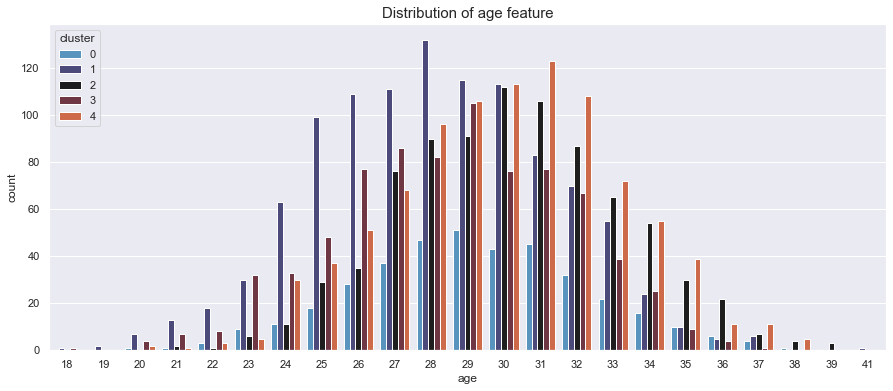

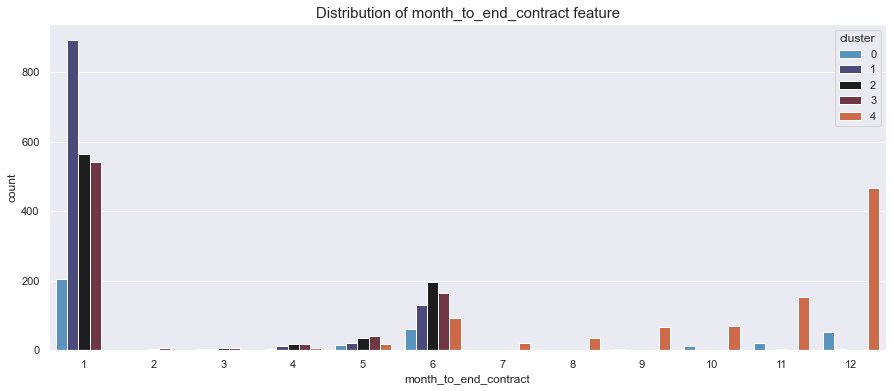

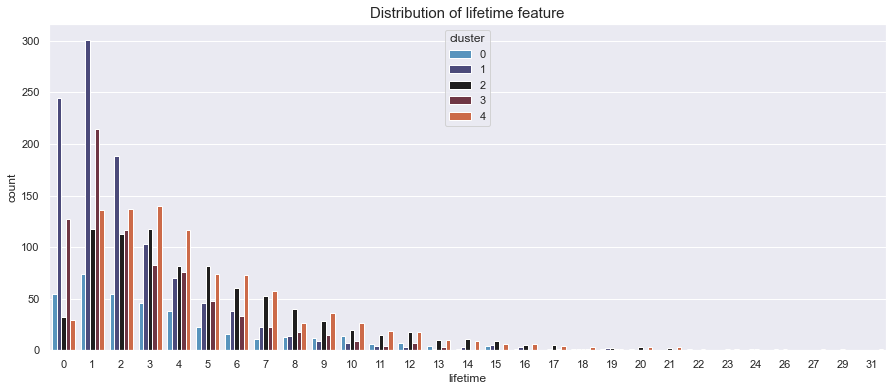

In [239]:
for col in feature_cols:
    sns.set_style('darkgrid')
    plt.figure(figsize=(15,6))
    sns.countplot(x=gym[col], hue='cluster',data=gym, palette="icefire")
    plt.title('Distribution of '+ col + ' feature', fontsize=15)
    plt.show()
    

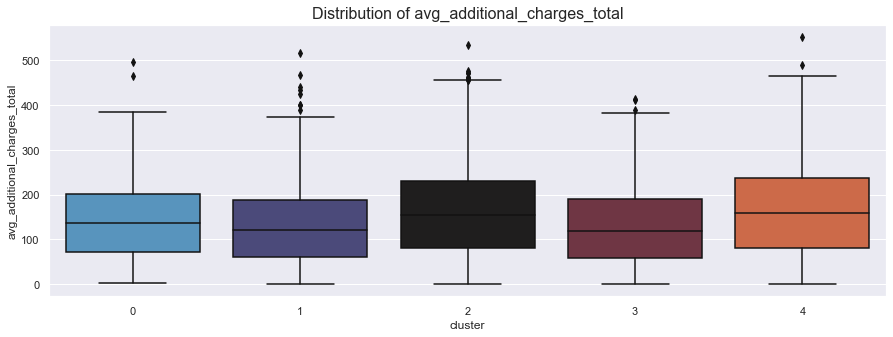

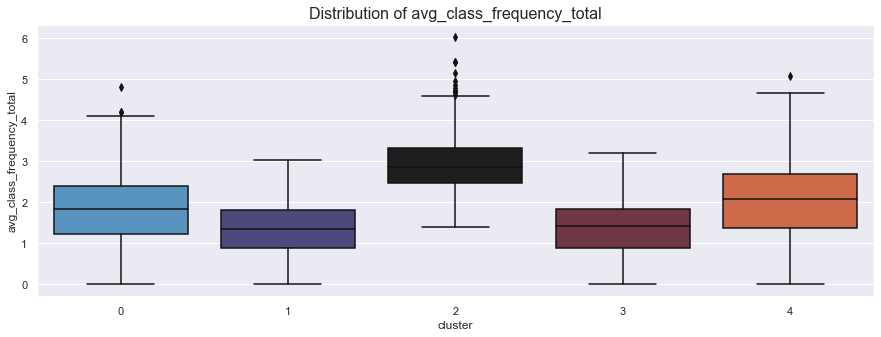

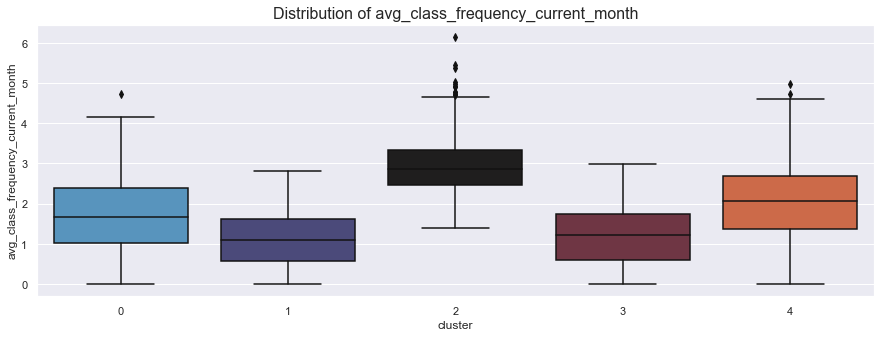

In [240]:
for col in numeric_cols:
    plt.figure(figsize=(15,5))
    sns.boxplot(x='cluster', y=gym[col],palette="icefire", data=gym)
    plt.title('Distribution of ' + col, fontsize=16)
    plt.show()


> **Cluster 0** 
> - 26% of clients left
> - Average age is 29
> - 86% of clients live near the gym 
> - Clients did not leave their contact info
> - 4 months average remaining before the contract expires

> - **Cluster 1** 
> - 55% of clients left
> - Average age is 28, the lowest out of all the groups
> - 81% of clients live near the gym 
> - None of the  clients are affilited with the company
> - Clients left their phone number
> - Averages about 1 visit per week
> - Lowest contract period - 1 month

> **Cluster 2** 
> - 4.8% of clients left
> - Average age is 30
> - 85% of clients live near the gym
> - Clients spent the most amount on addtional gym services
> - 33% of clients affiliated with the company
> - Clients left their phone number
> - Average contract period is 2.73
> - 5 months is the average lifetime of clients, which is the highest
> - Average 2 visits per week, the most out of the groups

> **Cluster 3**
> - 39% of clients left
> - Average age is 28
> - 75% of clients live near the gym
> - Clients left their phone number
> - 30% of clients attended group sessions, the lowest out of all the group
> - The lowest amount spent on additional gym services

> **Cluster 4** 
> - 2% of clients left
> - Average age is 29
> - Share of gender is equal
> - 94% of clients live near the gym 
> - 75% of clients affiliated with the company
> - More than half of the clients got a promo code from a friend
> - Clients left their phone number
> - Average contract period is 11 months, the most out of the groups
> - More than half of the clients attented group sessions, the highest out of all the groups
> - Average remaining months in their contract is 10 months
> - Most clients spent extra on other gym services, one of the highest
> - Average about 2 visits per week

### Calculate the churn rate for each cluster

In [241]:
churn_grouped = gym.groupby('cluster').mean().reset_index()[['cluster', 'churn']]
churn_grouped['churn_rate%'] = (churn_grouped['churn']*100).round(2)
churn_grouped[['cluster', 'churn_rate%']].sort_values(by='churn_rate%', ascending=False)

,cluster,churn_rate%
1,1,55.01
3,3,39.56
0,0,26.75
2,2,4.81
4,4,2.35


As we can see from above, clusters 1 and 3 are prone to leaving, with cluster 1 having the highest churn rate. Cluster 4 is the most loyal out of all them with the lowest churn rate. This cluster has the best indicators and we need to focus more on them.

## Step 5. Conclusions and recommendations

The data contains 4000 client entries regarding their visits and their membership status

Client general information:
 - The average contract period is about 5 months
 - Average client's age is 29
 - Client spend about $150 on other gym services such as cafe, massages,etc
 - The average amount of time that a customer has on their contract is 4 months and about half only have a month left
 - Gym clients go about twice a week on average
 - Churn rate is 26%
 
We trained the model on the train sample using accuracy, recall and precision metric using two methods:
- Logistic Regression
- Random Forest Classifier
- **Logistic regression model** gave a better result than the random forest model 

**Recommedations on customer interaction and retention:**
 - Clients younger than 30 tend to leave than the older ones. We should pay close attention to these age group if we want to lower our churn rate
 - Clients with a one month contract are prone to leaving, company should offer more incentive to drive these clients into longer term contracts
 - Clients not affiliated with the company are also more prone to churn, so it makes sense to extend discounts and promotions to these clients
 - We need to pay more attention when client's visits becomes more inconsistent. These clients have tendency to churn so make sure we pay close attention to them by contacting them through phone, sending reminders, etc.
 - We should also pay close attention to the clients who rarely spends or do not spend extra on other gym services, these clients are prone to leaving the gym. We could offer coupons or discounts when they visit the gym. We could also offer them rewards, the more they visit the gym, the higher the rewards/coupons.